In [647]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, f1_score, accuracy_score

from catboost import CatBoostClassifier, Pool, metrics, cv

In [648]:
df_train = pd.read_csv('train_meta.csv', index_col=0)
df_test = pd.read_csv('train_gts.csv', index_col=0)

#print(df_train[df_train["validated_by_human"] & df_train["initial_autogenerated_report"]].shape)
#null_value_stats = df_train.isnull().sum(axis=0)
#null_value_stats[null_value_stats != 0]

In [683]:
df_test.head(5)

,myocard
record_name,
00669_hr,0
00209_hr,0
00777_hr,0
01394_hr,0
01618_hr,0


In [682]:
df_train.head(3)


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
ecg_id,,,,,,,,,,,,,,,,,,,,,
9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,sinusrhythmus normales ekg,...,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,00009_hr,1
34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,"erneut vorhofflattern unter 3x1 cordichin ,1x0...",...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,00034_hr,3
43,11315.0,25.0,1,NaN,63.0,2.0,0.0,CS-12 E,1985-03-14 09:38:53,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,8,records100/00000/00043_lr,records500/00000/00043_hr,00043_hr,3


In [686]:
df = pd.merge(df_train, df_test, on='record_name', how='outer')
plt.rcParams['figure.figsize']=(30,30)

corr = df.corr()
#g = sns.heatmap(corr, square = True, annot=True)

C:\Users\sasha\AppData\Local\Temp\ipykernel_24536\796024386.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
ecg_id,,,,,,,,,,,,,,,,,,,,,
9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,sinusrhythmus normales ekg,...,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,00009_hr,1
34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,"erneut vorhofflattern unter 3x1 cordichin ,1x0...",...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,00034_hr,3
43,11315.0,25.0,1,NaN,63.0,2.0,0.0,CS-12 E,1985-03-14 09:38:53,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,8,records100/00000/00043_lr,records500/00000/00043_hr,00043_hr,3
52,18153.0,35.0,0,NaN,82.0,2.0,0.0,CS-12 E,1985-05-18 08:15:54,sinusrhythmus unvollstÄndiger rechtsschenkelbl...,...,NaN,NaN,NaN,NaN,NaN,1,records100/00000/00052_lr,records500/00000/00052_hr,00052_hr,2
57,16063.0,26.0,0,NaN,93.0,2.0,0.0,CS-12 E,1985-06-06 11:32:43,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,10,records100/00000/00057_lr,records500/00000/00057_hr,00057_hr,3


In [652]:
'''features = list(set(df.columns) - set(['DateTime']))

_ = df[features].hist(figsize=(20,12))'''

"features = list(set(df.columns) - set(['DateTime']))\n\n_ = df[features].hist(figsize=(20,12))"

In [653]:
df.drop(df[df["validated_by_human"] & df["initial_autogenerated_report"]].index,inplace=True,axis=0)
df.drop(df[df["validated_by_human"].isna() | df["initial_autogenerated_report"].isna()].index,inplace=True,axis=0)
df.shape

(1996, 30)

In [685]:
df_test.head(5)

,myocard
record_name,
00669_hr,0
00209_hr,0
00777_hr,0
01394_hr,0
01618_hr,0


In [654]:
df.fillna(0, inplace=True)

In [655]:
def fillmean(*col_names):
    for col in col_names:
        df[col].replace(0, df[df[col]!=0][col].mean(), inplace=True)
    print(df[list(col_names)].hist(figsize=(5*len(col_names),3)))

#fillmean("height","weight")

<Axes: >

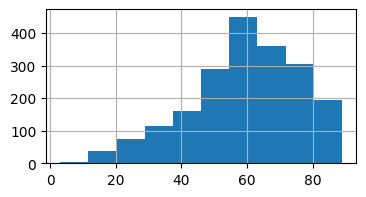

In [656]:
df.loc[df["age"]>100, ["age"]] = np.nan

df["age"].bfill(inplace=True)
df["age"].hist(figsize=(4,2))
# df["age"].replace(None, df["age"].mean())
#print(df.shape)

In [657]:
df.isna().sum().sum()

0

In [658]:
dtn = df.iloc[:,:-1]
ans = df.iloc[:,-1:]
#ans.head()

In [690]:
'''plt.rcParams['figure.figsize']=(10,10)

corr = dtn.corr()
g = sns.heatmap(corr, square = True, annot=True)'''

"plt.rcParams['figure.figsize']=(10,10)\n\ncorr = dtn.corr()\ng = sns.heatmap(corr, square = True, annot=True)"

In [669]:

X = dtn.drop(["filename_lr", "filename_hr", "record_name", "patient_id", "recording_date", "report", "scp_codes", "static_noise", "recording_date"], axis = 1)
#y = df_train["Energy city"]
#X = df_train[["age", "sex", "nurse", "site", "validated_by","second_opinion", "initial_autogenerated_report", "validated_by_human"]]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

cat_vars=['device', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'baseline_drift', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(X[var], prefix=var)
    data1=X.join(cat_list)
    X=data1

data_vars=X.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=X[to_keep]
X = X.drop(["device", "heart_axis", "infarction_stadium1", "infarction_stadium2", 'baseline_drift', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'pacemaker_0'], axis = 1)
X["second_opinion"] = X['second_opinion'].astype(int)
X["initial_autogenerated_report"] = X['initial_autogenerated_report'].astype(int)
X["validated_by_human"] = X['validated_by_human'].astype(int)
X.drop(['initial_autogenerated_report',"height"], axis = 1, inplace=True)

#X = dtn[["age", "sex", "height", "weight", "nurse","site"]]

In [661]:
#set(X.keys())

In [662]:
#dtn['scp_codes']

In [663]:
#set(X["group"])

In [664]:
# plt.rcParams['figure.figsize']=(177,177)

# corr = X.corr()
# g = sns.heatmap(corr, square = True, annot=True)

In [665]:
# ccccc=['baseline_drift_ , AVF',
#  'baseline_drift_ , AVR,V4',
#  'baseline_drift_ , I,AVR',
#  'baseline_drift_ , I,II,AVR,AVF',
#  'baseline_drift_ , I,II,III,AVL,AVR,AVF',
#  'baseline_drift_ , I,II,V2,V3',
#  'baseline_drift_ , I,III,AVL',
#  'baseline_drift_ , I,III,AVL,V3,V6',
#  'baseline_drift_ , I-AVF',
#  'baseline_drift_ , I-AVF,V6',
#  'baseline_drift_ , I-AVL',
#  'baseline_drift_ , I-AVR',
#  'baseline_drift_ , I-V1',
#  'baseline_drift_ , II,AVF',
#  'baseline_drift_ , II,III',
#  'baseline_drift_ , II,III,AVF',
#  'baseline_drift_ , II,III,AVF-V6',
#  'baseline_drift_ , II-AVF',
#  'baseline_drift_ , II-AVF,V6',
#  'baseline_drift_ , II-AVL',
#  'baseline_drift_ , II-AVL,AVF',
#  'baseline_drift_ , II-V1',
#  'baseline_drift_ , II-V6',
#  'baseline_drift_ , III',
#  'baseline_drift_ , III,AVF',
#  'baseline_drift_ , III,AVL',
#  'baseline_drift_ , III,AVL,AVF',
#  'baseline_drift_ , III,V2',
#  'baseline_drift_ , III,V3,V6',
#  'baseline_drift_ , III,V4,V5',
#  'baseline_drift_ , III,V5,V6',
#  'baseline_drift_ , V1',
#  'baseline_drift_ , V1,2',
#  'baseline_drift_ , V1,4,5,6',
#  'baseline_drift_ , V1,V3',
#  'baseline_drift_ , V1,V5,V6',
#  'baseline_drift_ , V1,V6',
#  'baseline_drift_ , V1-V3',
#  'baseline_drift_ , V2',
#  'baseline_drift_ , V2,V3',
#  'baseline_drift_ , V2-V4',
#  'baseline_drift_ , V3',
#  'baseline_drift_ , V3,5,6',
#  'baseline_drift_ , V4',
#  'baseline_drift_ , V4 stark',
#  'baseline_drift_ , V4,V5',
#  'baseline_drift_ , V4,V6',
#  'baseline_drift_ , V4-V6',
#  'baseline_drift_ , V5',
#  'baseline_drift_ , V5,V6',
#  'baseline_drift_ , V6',
#  'baseline_drift_ , alles',
#  'baseline_drift_ , drift',
#  'baseline_drift_ , v1',
#  'baseline_drift_ , v1-6',
#  'baseline_drift_ , v1-v4',
#  'baseline_drift_ , v2',
#  'baseline_drift_ , v2,4',
#  'baseline_drift_ , v3',
#  'baseline_drift_ , v4-6',
#  'baseline_drift_ , v5',
#  'baseline_drift_ , v6',
#  'baseline_drift_0',
#  'baseline_drift_I,V1-V4,  ',
#  'baseline_drift_I-III,V1-V3,  ',
#  'baseline_drift_II,III,  ',
#  'baseline_drift_V1-V3, V6',
#  'baseline_drift_V4,  ',
#  'baseline_drift_V4-V6,  ',
#  'baseline_drift_napf,  ',
#  'baseline_drift_v2,  ',
#  'baseline_drift_v3,  ']
# for i in ccccc:
#     print(list(X[i]).count(1))

In [666]:
y = ans["myocard"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=50)


In [681]:
categorical_features_indices = np.where(X.dtypes != float)[0]
mar=[]
score=0

params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'eval_metric': metrics.Accuracy(),
    'random_seed': 50,
    'logging_level': 'Silent',
    'use_best_model': True
}
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)
best_model = CatBoostClassifier(**params)
best_model.fit(train_pool, eval_set=validate_pool)

print(f1_score(y_test, best_model.predict(X_test).round().clip(0,1).astype(int)))

0.8039215686274509


In [668]:
categorical_features_indices = np.where(X.dtypes != float)[0]
mar=[]
score=0
for i in range(50,90,4):
    params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'eval_metric': metrics.Accuracy(),
    'random_seed': 50,
    'logging_level': 'Silent',
    'use_best_model': True
}
    train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
    validate_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)
    best_model = CatBoostClassifier(**params)
    best_model.fit(train_pool, eval_set=validate_pool)

    print("Seed:",i)
    print("F1:",score:=f1_score(y_test, best_model.predict(X_test).round().clip(0,1).astype(int)))
    print("accuracy:",accuracy_score(y_test, best_model.predict(X_test).round().clip(0,1).astype(int)))
    mar.append(score)

Seed: 50
F1: 0.8039215686274509
accuracy: 0.9089529590288316


KeyboardInterrupt: 

In [ ]:
np.array(mar).mean()

0.7959739527200916

In [675]:
models = [LinearRegression(),        # метод наименьших квадратов
	          RandomForestRegressor(200), # случайный лес
	          KNeighborsRegressor(100),   # метод ближайших соседей
	          SVR(kernel='linear')]    # метод опорных векторов с линейным ядром

In [678]:
model = models[3].fit(X_train, y_train)
f1_score(np.array(y_test), model.predict(X_test).round().clip(0,1).astype(int))

0.7898089171974522

In [ ]:
model.predict(X_test).round().clip(0,1).astype(int)

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

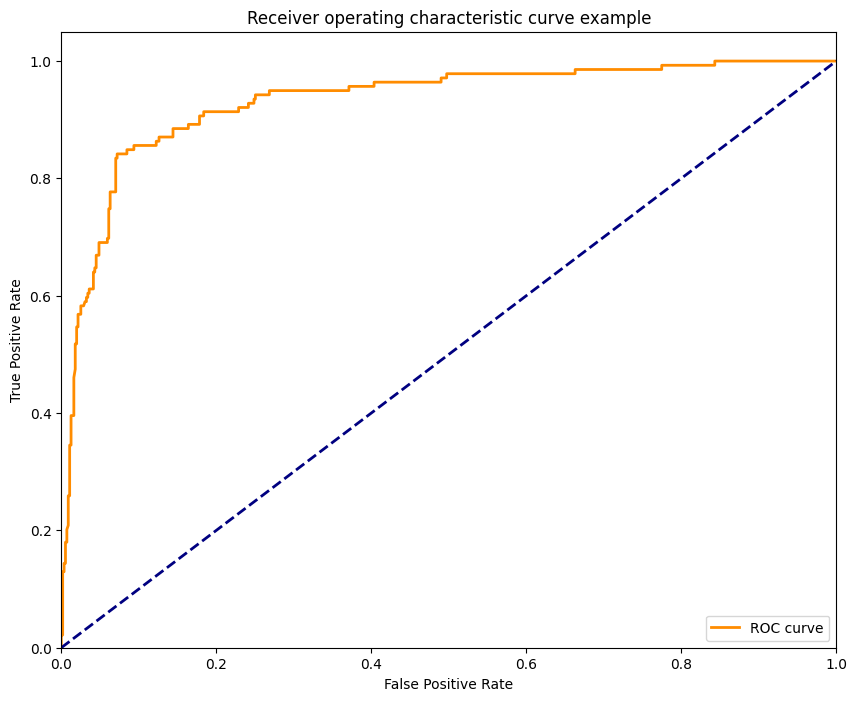

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np

y = np.array(y_test)
scores = np.array(best_model.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)

plt.figure(figsize=(10, 8))

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve example')
plt.legend(loc="lower right")
plt.show()